This example notebook shows how we can train an [image/digit classification](https://pytorch.org/tutorials/beginner/nn_tutorial.html?highlight=mnist)
model based on MNIST dataset, by employing TileDB as a storage engine for our training data and labels. We will first download the MNIST
dataset and ingest images and labels in two dense TileDB arrays. Continuing, we will use our TileDB support for PyTorch Dataloader API
in order to train a image classifier. First, let's import what we need and download our data.

In [1]:
import os
import idx2numpy
import numpy as np
import tiledb
import torch
import torchvision
import matplotlib.pyplot as plt

Download MNIST dataset.

In [2]:
data_home = os.path.join(os.path.pardir, "data")
data = torchvision.datasets.MNIST(root=data_home, train=False, download=True)

0.3%

100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




19.9%

100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
images = idx2numpy.convert_from_file(os.path.join(data_home, 'MNIST/raw/train-images-idx3-ubyte'))
labels = idx2numpy.convert_from_file(os.path.join(data_home, 'MNIST/raw/train-labels-idx1-ubyte'))

print("Images:", images.shape, images.dtype)
print("Labels:", labels.shape, labels.dtype)

Images: (60000, 28, 28) uint8
Labels: (60000,) uint8


Then we proceed with ingesting images and labels into dense TileDB arrays. Here, we should point out that besides the
flexibility of TileDB in defining a schema, i.e., multiple dimensions, multiple attributes, compression etc,
we choose to define a simple schema. So, for a numpy array of D number of dimensions we create a dense TileDB array,
with the same number of dimensions, and a single attribute of data type numpy float32. Moreover, the
tile extend of the 1st dimension should always be equal with the batch size, in order to achieve optimal reads while
training. Let's define an ingestion function.

In [4]:
def ingest_in_tiledb(data: np.array, batch_size: int, uri: str):
    # Equal number of dimensions with the numpy array.
    dims = [
        tiledb.Dim(
            name="dim_" + str(dim),
            domain=(0, data.shape[dim] - 1),
            tile=data.shape[dim] if dim > 0 else batch_size,
            dtype=np.int32,
        )
        for dim in range(data.ndim)
    ]

    # TileDB schema
    schema = tiledb.ArraySchema(
        domain=tiledb.Domain(*dims),
        sparse=False,
        attrs=[tiledb.Attr(name="features", dtype=data.dtype)],
    )
    # Create array
    tiledb.Array.create(uri, schema)

    # Ingest
    with tiledb.open(uri, "w") as tiledb_array:
        tiledb_array[:] = {"features": data}

Now we proceed with ingestion.

In [5]:
data_dir = os.path.join(data_home, 'readers', 'pytorch', 'dense')
os.makedirs(data_dir, exist_ok=True)

# Ingest images
training_images = os.path.join(data_dir, 'training_images')
if not os.path.exists(training_images):
    ingest_in_tiledb(data=images, batch_size=64, uri=training_images)

# Ingest labels
training_labels = os.path.join(data_dir, 'training_labels')
if not os.path.exists(training_labels):
    ingest_in_tiledb(data=labels, batch_size=64, uri=training_labels)

/Users/george/PycharmProjects/TileDB-ML/.venv/lib/python3.9/site-packages/tiledb/ctx.py:448: UserWarning: tiledb.default_ctx and scope_ctx will not function correctly due to bug in IPython contextvar support.  You must supply a Ctx object to each function for custom configuration options. Please consider upgrading to ipykernel >= 6!Please see https://github.com/TileDB-Inc/TileDB-Py/issues/667 for more information.
  warnings.warn(


We can now explore our TileDB arrays and check their structure.

In [6]:
images_array = tiledb.open(training_images)
labels_array = tiledb.open(training_labels)

print(images_array.schema)
print(labels_array.schema)

ArraySchema(
  domain=Domain(*[
    Dim(name='dim_0', domain=(0, 59999), tile=64, dtype='int32'),
    Dim(name='dim_1', domain=(0, 27), tile=28, dtype='int32'),
    Dim(name='dim_2', domain=(0, 27), tile=28, dtype='int32'),
  ]),
  attrs=[
    Attr(name='features', dtype='uint8', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
)

ArraySchema(
  domain=Domain(*[
    Dim(name='dim_0', domain=(0, 59999), tile=64, dtype='int32'),
  ]),
  attrs=[
    Attr(name='features', dtype='uint8', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
)



We can easily now slice our data and create some plots. We can either slice an image or a part of
an image. Because we use only one attribute, we always slice with attribute with index equal to 0.
Some examples below.

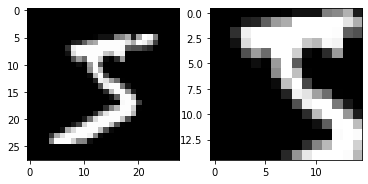

In [7]:
# Plot an image
plt.subplot(1, 2, 1)
plt.imshow(images_array[0][images_array.schema.attr(0).name], cmap="gray")

# Plot part of the same image
plt.subplot(1, 2, 2)
plt.imshow(images_array[0, 5:20, 5:20][images_array.schema.attr(0).name], cmap="gray")

Let's move on and create a TileDB loader that extends the PyTorch DataLoader API for training a machine learning model.

In [8]:
import multiprocessing
import torch.nn as nn
import torch.optim as optim

from tiledb.ml.readers.pytorch import PyTorchTileDBDataLoader
from tiledb.ml.readers.types import ArrayParams

class Net(nn.Module):
    def __init__(self, shape):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(np.product(shape), 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def do_random_noise(img, mag=0.1):
    noise = np.random.uniform(-1, 1,img.shape)*mag
    img = img + noise
    img = np.clip(img,0,1)
    return img

ctx = tiledb.Ctx({'sm.mem.total_budget': 1024**2})
with tiledb.open(training_images, ctx=ctx) as x, tiledb.open(training_labels, ctx=ctx) as y:
    # Because of this issue (https://github.com/pytorch/pytorch/issues/59451#issuecomment-854883855) we avoid using multiple workers on Jupyter.
    train_loader = PyTorchTileDBDataLoader(
        ArrayParams(x, fn=do_random_noise),
        ArrayParams(y),
        batch_size=128,
        num_workers=0,
        shuffle_buffer_size=256,
    )

    net = Net(shape=(28, 28))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

    for epoch in range(1, 3):
        net.train()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs.to(torch.float))
            loss = criterion(outputs, labels.to(torch.float).type(torch.LongTensor))
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} Batch: {} Loss: {:.6f}'.format(
                epoch, batch_idx, loss.item()))

Train Epoch: 1 Batch: 0 Loss: 2.304748
Train Epoch: 1 Batch: 100 Loss: 2.277155
Train Epoch: 1 Batch: 200 Loss: 2.203359
Train Epoch: 1 Batch: 300 Loss: 1.895098
Train Epoch: 1 Batch: 400 Loss: 1.497304
Train Epoch: 2 Batch: 0 Loss: 1.435658
Train Epoch: 2 Batch: 100 Loss: 1.305221
Train Epoch: 2 Batch: 200 Loss: 0.990590
Train Epoch: 2 Batch: 300 Loss: 1.103210
Train Epoch: 2 Batch: 400 Loss: 0.903957
